In [1]:
from random import choice, sample
from copy import deepcopy
from scipy.stats import bernoulli
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns

sns.set_style('white')
sns.set_context('paper')
%matplotlib inline

In [2]:
class Host(object):
    """docstring for Host"""
    def __init__(self, color):
        super(Host, self).__init__()
        self.color = color
        self.immunity = set()
        self.viruses = []
        self.expiry_time = 50
        self.alive_time = 0
        
    def is_infected(self):
        if len(self.viruses) > 0:
            return True
        else:
            return False
    
    def has_coinfection(self):
        if len(self.viruses) > 1:
            return True
        else:
            return False
        
    def replicate_virus(self):
        if not self.has_coinfection():
            virus = choice(self.viruses)
            seg1, seg2 = virus.seg1color, virus.seg2color
            new_virus = Virus(seg1, seg2)
            
        elif self.has_coinfection():
            # Perform reassortment
            v1, v2 = sample(self.viruses, 2)

            seg1 = choice([v1.seg1color, v2.seg1color])
            seg2 = choice([v1.seg2color, v2.seg2color])

            new_virus = Virus(seg1, seg2)
        
        self.viruses.append(new_virus)
        
    def increment_time(self):
        for v in self.viruses:
            v.infection_time += 1
            
            if v.infection_time > v.expiry_time:
                self.immunity.add(v.seg1color)
        self.alive_time += 1
        
    def remove_old_viruses(self):
        for v in self.viruses:
            if v.infection_time > v.expiry_time:
                self.viruses.remove(v)
    
    def remove_immune_viruses(self):
        for v in self.viruses:
            if v.seg1color in self.immunity:
                self.viruses.remove(v)
    
class Virus(object):
    """docstring for Virus"""
    def __init__(self, seg1color, seg2color):
        super(Virus, self).__init__()
        self.seg1color = seg1color
        self.seg2color = seg2color
        self.infection_time = 0  # time of infection
        self.expiry_time = 5  # num. days to immunity
        
    def is_mixed(self):
        if self.seg1color != self.seg2color:
            return True
        else:
            return False

In [3]:

## This block of code is for the simulation

# Initialize a NetworkX directed graph to summarize the virus-host interactions.
# Nodes are the host colors.
# Edges denote same-host or diff-host transmission.
# At each transmission event, capture the old host and new host colors. Also, capture whether the virus transmitted
# was a reassortant (i.e. mixed color) virus or not.
G = nx.DiGraph()
G.add_node('blue')
G.add_node('red')
G.add_edge('blue', 'blue', mixed=0, clonal=0)
G.add_edge('red', 'red', mixed=0, clonal=0)
G.add_edge('blue', 'red', mixed=0, clonal=0)
G.add_edge('red', 'blue', mixed=0, clonal=0)

# Initialize 50 hosts, 25 red and 25 blue.
hosts = []
n_hosts = 1000
for i in range(n_hosts):
    if i < n_hosts / 2:
        hosts.append(Host(color='blue'))
    else:
        hosts.append(Host(color='red'))

# Pick 5 red hosts and 5 blue hosts at random, and infect it with a virus of the same color.
blue_hosts = [h for h in hosts if h.color == 'blue']
blue_hosts = sample(blue_hosts, 5)
blue_virus = Virus(seg1color='blue', seg2color='blue')
for h in blue_hosts:
    h.viruses.append(blue_virus)

red_hosts = [h for h in hosts if h.color == 'red']
red_hosts = sample(red_hosts, 5)
red_virus = Virus(seg1color='red', seg2color='red')
for h in red_hosts:
    h.viruses.append(red_virus)

# Set up parameters
p_immune = 1E-3   # 1 = always successful even under immune pressure
                 # 0 = always unsuccessful under immune pressure.
p_replicate = 0.95  # probability of replication given that a virus is infected.
p_contact   = 1 - 1E0/n_hosts  # probability of contacting a host of the same color.
p_same_color = 0.99  # probability of successful infection given segment of same color.
p_diff_color = 0.9   # probability of successful infection given segment of different color.

# Set up number of timesteps to run simulation
n_timesteps = 100

# Set up a defaultdict for storing data
data = defaultdict(list)
# n_infected = []  # number of infected hosts
# n_immune = []  # number of immune hosts (to red and blue)
# n_blue_immune = []  # number of blue immune hosts
# n_red_immune = []  # number of red immune hosts
# n_uninfected = []  # number of uninfected hosts
# n_original = []  # number of original colored viruses (i.e. all red or all blue)
# n_blue_virus = []  # number of blue viruses
# n_red_virus = []  # number of red viruses
# n_mixed = []  # number of mixed viruses
# n_contacts = []  # number of different-colored host contacts

# Run simulation
for t in range(n_timesteps):  
    # First part, clear up old infections.
    for h in hosts:
        h.increment_time()
        h.remove_old_viruses()
        h.remove_immune_viruses()
        
    # Step to replicate viruses present in hosts.
    infected_hosts = [h for h in hosts if h.is_infected()]
    for h in infected_hosts:
        if bernoulli.rvs(p_replicate): # we probabilistically allow replication to occur
            h.replicate_virus()
    
    # Step to transmit the viruses present in hosts.
    infected_hosts = [h for h in hosts if h.is_infected()]
    num_contacts = 0
    for h in infected_hosts:
        same_color = bernoulli.rvs(p_contact)
        if same_color:
            new_host = choice([h2 for h2 in hosts if h2.color == h.color])
            num_contacts += 0
        else:
            new_host = choice([h2 for h2 in hosts if h2.color != h.color])
            num_contacts += 1
        virus = h.viruses[-1] # choose the newly replicated virus every time.
        
        # Determine whether to transmit or not.
        p_transmit = 1
        ### First, check immunity ###
        if virus.seg1color in new_host.immunity:
            p_transmit = p_transmit * p_immune
        elif virus.seg1color not in new_host.immunity:
            pass
        
        ### Next, check seg1.
        if virus.seg1color == new_host.color:
            p_transmit = p_transmit * p_same_color
        else:
            p_transmit = p_transmit * p_diff_color
        
        ### Finally, check seg2.
        if virus.seg2color == new_host.color:
            p_transmit = p_transmit * p_same_color
        else:
            p_transmit = p_transmit * p_diff_color

        # Determine whether to transmit or not, by using a Bernoulli trial.
        transmit = bernoulli.rvs(p_transmit)
        
        # Perform transmission step
        if transmit:
            new_host.viruses.append(virus)
            # Capture data in the summary graph.
            if virus.is_mixed():
                G.edge[h.color][new_host.color]['mixed'] += 1
            else:
                G.edge[h.color][new_host.color]['clonal'] += 1
        else:
            pass
        
        
    ### INSPECT THE SYSTEM ###
    # Figure out how many hosts are immune.
    num_immunes = 0
    num_infected = 0
    num_blue_immune = 0
    num_red_immune = 0
    num_uninfected = 0
    num_mixed = 0
    num_original = 0
    num_red_virus = 0
    num_blue_virus = 0
    
    for h in hosts:
        if len(h.immunity) > 0:
            num_immunes += 1
        if h.is_infected() > 0:
            num_infected += 1
        if 'blue' in h.immunity:
            num_blue_immune += 1
        if 'red' in h.immunity:
            num_red_immune += 1
        if not h.is_infected():
            num_uninfected += 1
            
        for v in h.viruses:
            if v.is_mixed():
                num_mixed += 1
            else:
                if v.seg1color == 'blue' and v.seg2color == 'blue':
                    num_blue_virus += 1
                elif v.seg1color == 'red' and v.seg2color == 'red':
                    num_red_virus += 1
                num_original += 1
    data['n_immune'].append(num_immunes)
    data['n_infected'].append(num_infected)
    data['n_blue_immune'].append(num_blue_immune)
    data['n_red_immune'].append(num_red_immune)
    data['n_uninfected'].append(num_uninfected)
    data['n_mixed'].append(num_mixed)
    data['n_original'].append(num_original)
    data['n_red_virus'].append(num_red_virus)
    data['n_blue_virus'].append(num_blue_virus)
    data['n_contacts'].append(num_contacts)
    ### INSPECT THE SYSTEM ###
    


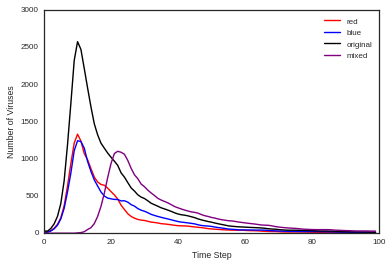

In [4]:
# Reassortment successful in establishing infection or not?
plt.plot(data['n_red_virus'], color='red', label='red')
plt.plot(data['n_blue_virus'], color='blue', label='blue')
plt.plot(data['n_original'], color='black', label='original')
plt.plot(data['n_mixed'], color='purple', label='mixed')
plt.ylabel('Number of Viruses')
plt.xlabel('Time Step')
plt.legend()

In [5]:
np.array_equal(np.array(data['n_mixed']), np.zeros(100))

False

In [6]:
np.where(np.array(data['n_mixed']) == np.max(data['n_mixed']))[0] - np.where(np.array(data['n_original']) == np.max(data['n_original']))[0]

array([12])

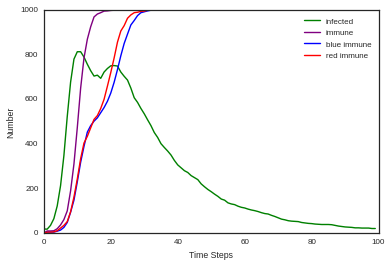

In [7]:
plt.plot(data['n_infected'], color='green', label='infected')
plt.plot(data['n_immune'], color='purple', label='immune')
plt.plot(data['n_blue_immune'], color='blue', label='blue immune')
plt.plot(data['n_red_immune'], color='red', label='red immune')
plt.ylabel('Number')
plt.xlabel('Time Steps')
plt.legend()

array([ 6,  8, 11, 12, 13, 14, 19, 20, 21, 22, 23, 27, 28, 30, 34, 35, 37,
       45, 48, 59, 61, 81, 98])

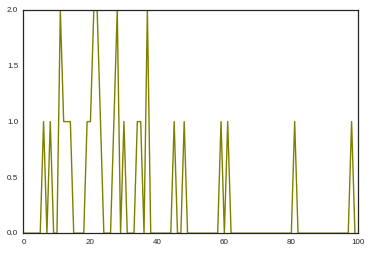

In [8]:
plt.plot(data['n_contacts'], color='olive', label='contacts')

np.where(np.array(data['n_contacts']) >= 1)[0]

In [13]:
import pandas as pd
pd.DataFrame(data)

,n_blue_immune,n_blue_virus,n_contacts,n_immune,n_infected,n_mixed,n_original,n_red_immune,n_red_virus,n_uninfected
0,0,15,0,0,19,0,30,0,15,981
1,5,13,0,10,18,0,27,5,14,982
2,5,29,0,10,35,0,63,5,34,965
3,5,59,0,11,65,0,125,6,66,935
4,9,107,0,20,122,0,226,11,119,878
5,14,192,0,37,213,0,399,23,207,787
6,26,335,1,61,348,0,706,35,371,652
7,48,555,0,100,523,0,1190,52,635,477
8,94,808,1,190,677,0,1745,96,937,323
9,148,1109,0,310,780,0,2321,162,1212,220
